# Data processing

Data pre-processing and exploratory analysis of restaurant inspections data before modeling

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.api import OLS

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

%matplotlib inline

PATH_YELP_DATA = '../data/yelp_data.csv'
PATH_INSPECTIONS = '../data/nyc_restaurant_inspection_data.csv'
PATH_DEMOGRAPHICS = '../data/demographics_zipcode.csv'

## Data preparation

In [2]:
def load_inspections (url=PATH_INSPECTIONS):
    """Creates DF from NYC inspections data and handles preliminary
    data-cleaning. Sets CAMIS as index.

    Raises:
        RuntimeError if number of rows after cleaning data are fewer than 150K.
    """
    df = pd.read_csv(url)
    # Remove records not containing a zip code and ensure zip code is an int.
    # df = df[df['ZIPCODE'].notnull()]
    df['ZIPCODE'] = df['ZIPCODE'].astype(np.int64)
    if len(df.index) < 150000:
        raise RuntimeError('Inspections DF contains < 150,000 rows.')
    return df


def load_yelp (url=PATH_YELP_DATA):
    """Sets CAMIS as index."""
    df = pd.read_csv(url, encoding='ISO-8859-1')
    df['zip_code'] = df['zip_code'].astype(np.int64)
    df.set_index('CAMIS', inplace=True, drop=False)
    if len(df.index) < 9500:
        raise RuntimeError('Yelp DF contains < 9,500 rows.')
    return df


def load_complete_data ():
    inspections = load_inspections()
    yelp = load_yelp()
    result = pd.merge(inspections, yelp, how='left', on='CAMIS')
    return result

In [3]:
data = load_complete_data()

In [4]:
# Check dimensions of dataset
n, p = data.shape
print(f"Number of observations: {n}")
print(f"Number of predictors: {p}")

Number of observations: 157955
Number of predictors: 33


In [5]:
# Column names and types
data.dtypes

CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                    int64
PHONE                     object
CUISINE.DESCRIPTION       object
INSPECTION.DATE           object
ACTION                    object
VIOLATION.CODE            object
VIOLATION.DESCRIPTION     object
CRITICAL.FLAG             object
SCORE                    float64
GRADE                     object
GRADE.DATE                object
RECORD.DATE                int64
INSPECTION.TYPE           object
id                        object
name                      object
url                       object
phone                    float64
latitude                 float64
longitude                float64
review_count               int64
price                    float64
rating                   float64
transactions              object
categories                object
address                   object
city      

In [6]:
# Update column names with "_" separator
data.columns = [c.replace(".", "_").lower() for c in data.columns]

In [7]:
# Number of unique values for specified columns
cols = ['camis', 'zipcode', 'violation_code', 'cuisine_description', 'transactions', 'categories']
for c in cols:
    cnt = data[c].nunique()
    print("{}: {}".format(c, cnt))

camis: 9509
zipcode: 196
violation_code: 98
cuisine_description: 83
transactions: 13
categories: 3446


In [8]:
# Function to fix date formats 
from datetime import date, timedelta
def get_excel_date(row):
    if row==row:
        try:
            if len(row)==5:
                return date(1900, 1, 1) + timedelta(int(row))
            else:
                return pd.to_datetime(row).strftime('%Y-%m-%d')
        except:
            None
    else:
        return None

In [9]:
# Fix formats of date columns
date_cols = ['inspection_date', 'grade_date', 'record_date']
for col in date_cols:
    data[col] = data[col].apply(get_excel_date)
    
# Create inspection date variables
data['inspection_year'] = pd.DatetimeIndex(data['inspection_date']).year
data['inspection_month'] = pd.DatetimeIndex(data['inspection_date']).month

In [10]:
# Drop observations with no score 
data = data[pd.notnull(data.score)]

# Drop observations with a negative score
data = data[data.score >= 0]
      
# Replace missing values with "NULL" 
#   This causes issues when doing group by below
data.fillna("NULL", inplace=True)

# Number of unique observations (restaurant, inspection date)
count = len(data[["camis", "inspection_date"]].drop_duplicates())
print("Number of unique observations: {}".format(count))

Number of unique observations: 52472


In [11]:
model_cols = ['camis',
              'dba',
              'boro',
              'zipcode',
              'cuisine_description',
              'inspection_date',
              'inspection_year',
              'inspection_month',
              'score',
              'grade',
              'name',
              'latitude',
              'longitude',
              'review_count',
              'price',
              'rating',
              'transactions',
              'categories',
              'city']

# Group violations such that each observation in data is an individual inspection
grp = data.groupby(model_cols, group_keys=True)['violation_code'].apply(list)
data = pd.DataFrame(grp.reset_index())

In [12]:
# Ensure observations are unique by camis and inspection date
# Take observation with lowest score if multiple entries exist

# Rank duplicate observations by score
g = data.sort_values(['camis', 'inspection_date', 'score']).groupby(['camis', 'inspection_date'])
data['RNK'] = g['score'].rank(method='first')

# Drop duplicates
n = len(data)
data = data.loc[data.RNK == 1, :]
data.drop('RNK', axis=1, inplace=True)

# Set index
data.set_index(['camis', 'inspection_date'], drop=False, verify_integrity=True, inplace=True)

## Feature engineering

**Cuisine description**

In [13]:
def fix_cuisine_format(row):

    mapping = {
        'Bottled beverages, including water, sodas, juices, etc.': 'Bottled_beverages',
        'CafÃ©/Coffee/Tea': 'Coffee_Tea',
        'Ice Cream, Gelato, Yogurt, Ices': 'IceCream_Gelato',
        'Juice, Smoothies, Fruit Salads': 'Juice_Smoothies',
        'Latin (Cuban, Dominican, Puerto Rican, South & Central American)': 'Latin',
        'Sandwiches/Salads/Mixed Buffet': 'Sandwiches',
        'Soups & Sandwiches': 'Sandwiches',
        'Tex-Mex': 'TexMex'
    }
    
    try:
        row = mapping[row]
    except:
        row = row.strip().replace("/", "_").replace(" ", "_")
    
    return row
        
data['cuisine_description'] = data['cuisine_description'].apply(fix_cuisine_format)

In [14]:
def fix_list_format(row):
    
    row = str(row)
    
    chars = ''''"[]'''
    for c in chars:
        row = row.strip().replace(c, "")
    row = row.replace(",", "|").replace(" ", "")
    
    return row

**Transactions**

In [15]:
# Clean values
data['transactions'] = data['transactions'].apply(fix_list_format)

# Get unique set of transactions
transactions = set()
for s in data.transactions:
    transactions.update(s.split('|'))

# Create separate columns for each unique value
for txn in transactions:
    data["trans_" + txn] = [1 if txn in t.split('|') else 0 for t in data.transactions]
    
# Drop column
data.drop('transactions', axis=1, inplace=True)

**Categories**

In [16]:
# Clean up categories column
data['categories'] = data['categories'].apply(fix_list_format)
print("Total number of category combinations: {}".format(data.categories.nunique()))

# Get set of unique categories
categories = set()
for s in data.categories:
    categories.update(s.split('|'))
print("Total number of unique categories: {}".format(len(categories)))

# Create column for each unique category and encode 
#    Might need to refine this later to reduce dimensionality
for cat in categories:
    data["cat_" + cat] = [1 if cat in c.split('|') else 0 for c in data.categories]
    
# Drop column
data.drop('categories', axis=1, inplace=True)

Total number of category combinations: 3423
Total number of unique categories: 309


**Violations**

In [17]:
# Clean up categories column
data['violation_code'] = data['violation_code'].apply(fix_list_format)
print("Total number of violation combinations: {}".format(data.violation_code.nunique()))

# Get set of unique categories
violations = set()
for s in data.violation_code:
    violations.update(s.split('|'))
print("Total number of unique violations: {}".format(len(violations)))

# Create column for each unique category and encode 
#    Might need to refine this later to reduce dimensionality
for vcode in violations:
    data["violation_" + vcode] = [1 if vcode in v.split('|') else 0 for v in data.violation_code]
    
# Drop column
data.drop('violation_code', axis=1, inplace=True)

Total number of violation combinations: 17796
Total number of unique violations: 70


**Restaurant name**

In [18]:
# Length of restuarant name in inspection data
data["restaurant_name_len"] = data["dba"].apply(len)

# Length of restaurant name in Yelp data
data["restaurant_name_len_yelp"] = data["name"].apply(len)

# Similarity of names in inspection data and Yelp data
data["restaurant_name_sim"] = data.apply(lambda row: distance.levenshtein(row["dba"], row["name"]), axis=1)

# Number of observations by restaurant 
df = data.dba.value_counts().reset_index()
df.columns = ['dba', 'restaurant_name_count']
data = pd.merge(data, df, how='left', on='dba')

# Create initial flag for restaurant chains (count > 50)
data["restaurant_name_chain"] = data['restaurant_name_count'].apply(lambda x: 1 if x > 50 else 0)

# Drop column
data.drop('name', axis=1, inplace=True)

**Demographics by zipcode**

In [19]:
# Import data
cen_data = pd.read_csv(PATH_DEMOGRAPHICS)

# Update column names
cen_data.columns =  ["cen_" + c.replace(" ", "_").lower() for c in cen_data.columns]
cen_data.columns.values[0] = 'zipcode'

# Merge onto base dataset
data = pd.merge(data, cen_data, how='left', on='zipcode')

**Region**

In [20]:
# Borough
##########

# Create dummy variables
col = 'boro'
df = pd.get_dummies(data[col], prefix=col)
data = data.join(df)
data.drop(col, axis=1, inplace=True)

# City
#########

# Group areas with low volumes
col = 'city'
counts = list(pd.value_counts(data[col]).index[:30])
data[col] = data[col].apply(lambda row: row if row in counts else 'Other')

# Create dummy variables
df = pd.get_dummies(data[col], prefix=col)
data = data.join(df)
data.drop(col, axis=1, inplace=True)

In [21]:
# Clean up column names (lowercase and no spaces)
data.columns = [c.replace(".", "_").lower() for c in data.columns]

# Replace NULL with NA again
data.replace("NULL", np.nan, inplace=True)

# Impute missing values (categorical)
cols = ['rating', 'price']
imp = Imputer(missing_values="NaN", strategy="most_frequent")
data[cols] = imp.fit_transform(data[cols])

# Census values
imp = Imputer(missing_values="NaN", strategy="mean")
cols = [c for c in data.columns if c[:3] == "cen"]
data[cols] = imp.fit_transform(data[cols])

# Reorder columns
cols = list(data.columns)
target_cols = ['grade', 'score']
for c in target_cols:
    cols.remove(c)
    cols.append(c)

data = data[cols]

#Export data to csv
#data.to_csv('data/model_data.csv')

## Exploratory data analysis

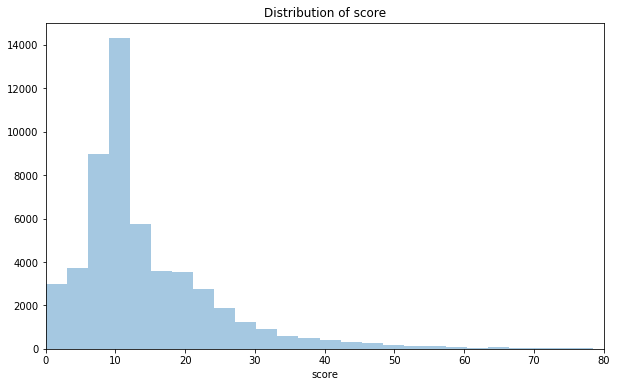

In [22]:
# Distribution of score
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 80)
ax.set_title("Distribution of score")
sns.distplot(data.score, kde=False);

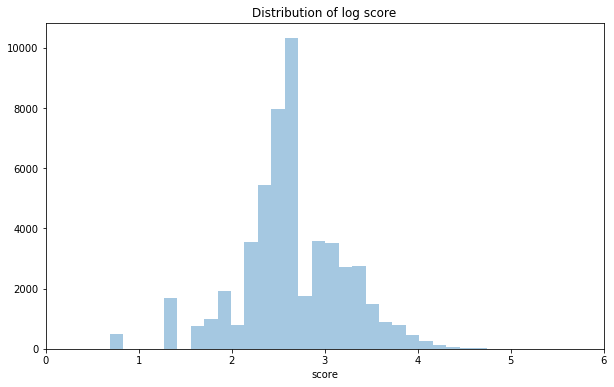

In [23]:
# Distribution of log score
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 6)
ax.set_title("Distribution of log score")
sns.distplot(np.log(data.score+2), bins=30, kde=False);

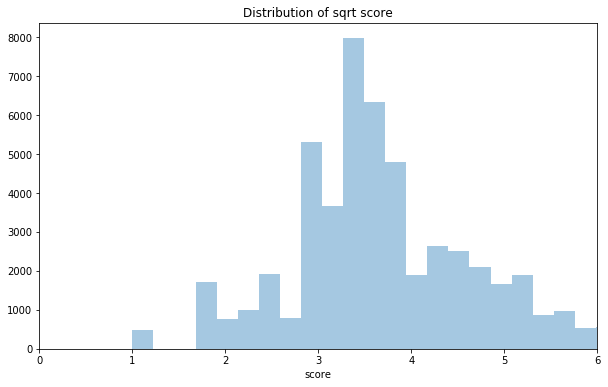

In [24]:
# Distribution of sqrt score
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 6)
ax.set_title("Distribution of sqrt score")
sns.distplot(np.sqrt(data.score+1), bins=50, kde=False);

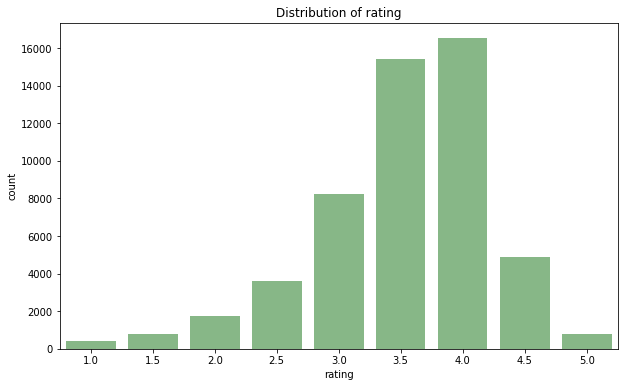

In [25]:
# Distribution of rating
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title("Distribution of rating")
sns.countplot(x="rating", data=data, color='green', alpha=0.5);

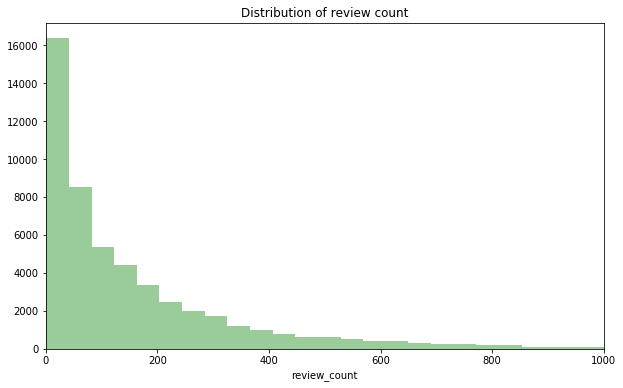

In [26]:
# Distribution of number of reviews
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title("Distribution of review count")
ax.set_xlim(0, 1000)
sns.distplot(data.review_count, kde=False, bins=200, color='green');

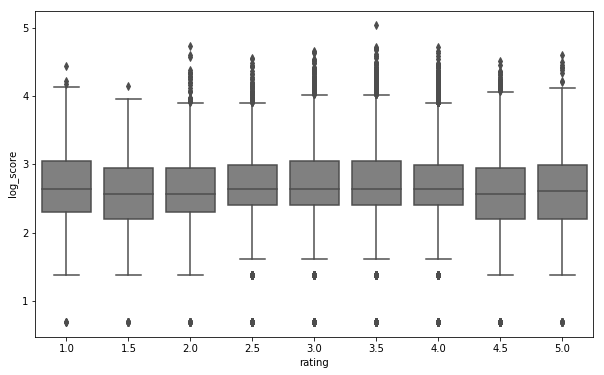

In [27]:
# Distribution of scores by rating
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
data['log_score'] = np.log(data['score']+2)
sns.boxplot(x="rating", y="log_score", data=data, color='grey', saturation=0.5);

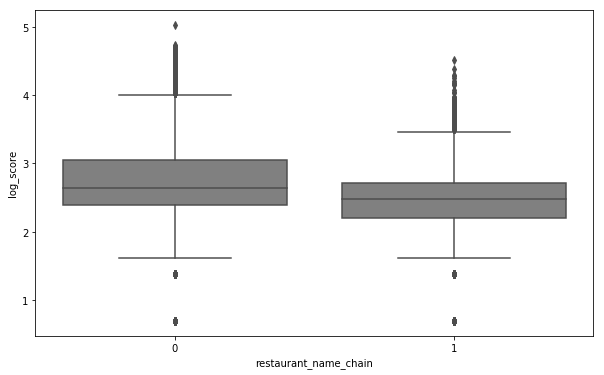

In [28]:
# Distribution of scores by restaurant chain flag
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(x="restaurant_name_chain", y="log_score", data=data, color='grey', saturation=0.5);

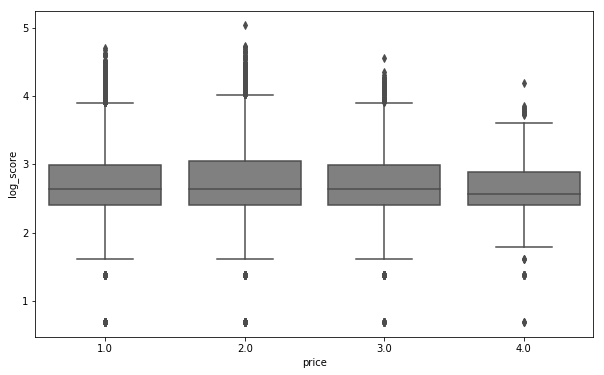

In [29]:
# Distribution of scores by restaurant chain flag
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(x="price", y="log_score", data=data, color='grey', saturation=0.5);

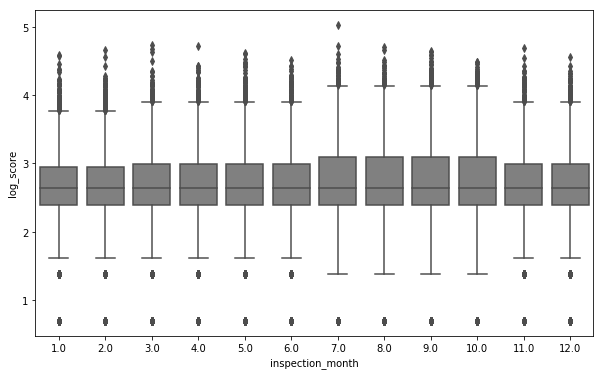

In [30]:
# Distribution of scores by restaurant chain flag
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(x="inspection_month", y="log_score", data=data, color='grey', saturation=0.5);

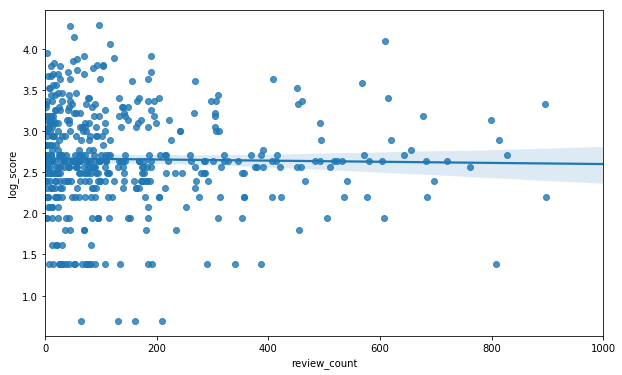

In [31]:
df = data.sample(500)

# Distribution of scores by restaurant chain flag
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 1000)
sns.regplot(x="review_count", y="log_score", data=df);

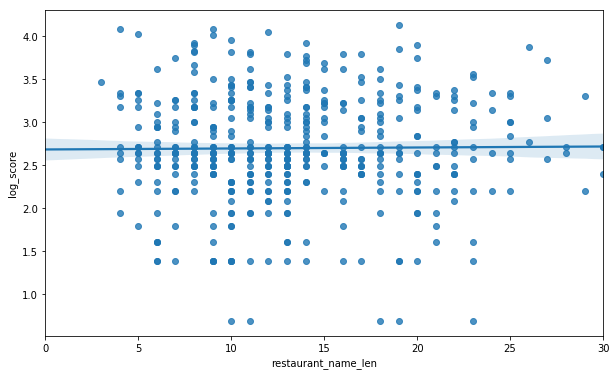

In [32]:
df = data.sample(500)

# Distribution of scores by restaurant chain flag
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 30)
sns.regplot(x="restaurant_name_len", y="log_score", data=df);

## Initial modeling

**Let's just look at couple of predictors to start**

In [33]:
model_cols = ['review_count', 'price', 'rating', 'log_score']

# Get predictors and response
df = data[model_cols]

# Create train and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
print(res.summary(xname=names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.29
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           9.14e-07
Time:                        17:52:58   Log-Likelihood:                -22483.
No. Observations:               26230   AIC:                         4.497e+04
Df Residuals:                   26226   BIC:                         4.501e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.6866      0.020    136.322   

**Violation codes? Expected to be very correlated by construction**

In [34]:
model_cols = [c for c in data.columns if "violation" in c][:20]
model_cols.append('log_score')

# Get predictors and response
df = data[model_cols]

# Create train and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
print(res.summary(xname=names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     530.0
Date:                Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:52:58   Log-Likelihood:                -18428.
No. Observations:               26230   AIC:                         3.689e+04
Df Residuals:                   26211   BIC:                         3.705e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.4260      0.004    624.366

**Areas? Don't expect this to be very important**

In [35]:
model_cols = [c for c in data.columns if c[:4] == "city"]
model_cols.append('log_score')

# Get predictors and response
df = data[model_cols]

# Create train and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
print(res.summary(xname=names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.995
Date:                Mon, 16 Jul 2018   Prob (F-statistic):           7.20e-08
Time:                        17:52:58   Log-Likelihood:                -22453.
No. Observations:               26230   AIC:                         4.497e+04
Df Residuals:                   26199   BIC:                         4.522e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [36]:
# Let's fit a LASSO model to subset the most important features

first_index = data.columns.get_loc("review_count")
last_index = data.columns.get_loc("city_woodside")

model_cols = list(data.columns[first_index: last_index + 1])
model_cols = [c for c in model_cols if "violation" not in c]
model_cols.append('log_score')

# Get predictors and response
df = data[model_cols]

# Model predictors
X_train = df.iloc[:,:-1].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Response
y_train = df.iloc[:,-1].values

# Fit LASSO model
shrinkage = [0.01]
mod = LassoCV(alphas=shrinkage, cv=10)
lasso = mod.fit(X_train, y_train)

# Print summary statistics
df = pd.DataFrame(lasso.coef_, columns=["Coefficient"], index=model_cols[:-1])
df[df.Coefficient != 0]

rsq = r2_score(y_train, lasso.predict(X_train))
print("Training R-squared: {0:.4f}".format(rsq))

Training R-squared: 0.0286


## Add more features

In [37]:
data_keep = data.copy()

**Cuisine description**

In [38]:
# Group areas with low volumes
col = 'cuisine_description'
counts = list(pd.value_counts(data[col]).index[:30])
data[col] = data[col].apply(lambda row: row if row in counts else 'Other')

# Create dummy variables
df = pd.get_dummies(data[col], prefix=col)
data = data.join(df)
data.drop(col, axis=1, inplace=True)

**Previous score / time since previous inspection**

In [39]:
import warnings
warnings.filterwarnings('ignore')

data = data_keep.copy()

# Join on previous scores
df = pd.merge(data[['camis', 'inspection_date']],
              data[['camis', 'inspection_date', 'score']], on='camis', suffixes=('', '_prev'))
df = df.loc[df['inspection_date'] > df['inspection_date_prev'], :]

# Months since previous inspection
df['time_since_prev'] = df['inspection_date'] - df['inspection_date_prev']

# Most recent score
g = df.sort_values(['camis', 'inspection_date', 'time_since_prev']).groupby(['camis', 'inspection_date'])
df['rnk'] = g['time_since_prev'].rank(method='first')

# Average historic scores
df.set_index(['camis', 'inspection_date'], inplace=True, drop=False)
g = df.groupby(['camis', 'inspection_date'])['score']
df['score_avg'] = g.mean()
df['score_std'] = g.std()
df['score_max'] = g.max()
df['score_cnt'] = g.count()

# Unique index
df = df.loc[df['rnk'] == 1, :]
df.drop('rnk', axis=1, inplace=True)

# Join back onto base dataframe
data = pd.merge(data, df[['camis', 'inspection_date', 'score', 'score_avg', 'score_std', 
                          'score_max', 'score_cnt', 'time_since_prev']], 
                how='left', on=['camis', 'inspection_date'], suffixes=('', '_prev'))

# Fraction of year since previous visit
data['time_since_prev'] = data['time_since_prev'].dt.days / 365

# Set index
data.set_index(['camis', 'inspection_date'], drop=False, verify_integrity=True, inplace=True)

# Flag if first inspection
data['first_inspection'] = data['time_since_prev'].apply(lambda row: 0 if row == row else 1)

# Impute missing values
cols = ['score_prev', 'score_avg', 'score_std', 'score_max', 'score_cnt', 'time_since_prev']
imp = Imputer(missing_values="NaN", strategy="mean")
data[cols] = imp.fit_transform(data[cols])


**Restaurant category (Yelp data)**

In [40]:
# Large number of categories (~300) so drop categories
# with observations lower than some threshold

min_obs = 500

cols = [c for c in data.columns if c[:3] == "cat"]
for c in cols:
    if data[c].sum() < min_obs:
        data.drop(c, axis=1, inplace=True)
        

In [41]:
# Clean up column names (lowercase and no spaces)
data.columns = [c.replace(".", "_").lower() for c in data.columns]

# Reorder columns
cols = list(data.columns)
target_cols = ['grade', 'score', 'log_score']
for c in target_cols:
    cols.remove(c)
    cols.append(c)
data = data[cols]


In [42]:
#Export data to csv
#data.to_csv('data/model_data.csv')